In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import subprocess

In [2]:
# GLOBAL PATH VARIABLE FOR AUDIO / TXT FILES:
path = 'respiratory-sound-database/audio_and_txt_files/'

In [3]:
def get_audio_files():
    folder = os.listdir(path)

    wav_files, txt_files = [], []
    for file in folder:
        if file.endswith('_16.wav'):
            wav_files.append(file)
        elif file.endswith('.txt'):
            txt_files.append(file)

    return wav_files, txt_files

In [4]:
def extract_info(filename):
    splits = filename.split('_')
    print(splits)

In [5]:
# separate files by audio and txt
wav_files, txt_files = get_audio_files()
wav_files = sorted(wav_files)
txt_files = sorted(txt_files)

In [6]:
# extract information from the wav files' filename
# 0:[patient #], 1:[recording index], 2:[chest location], 3:[acquisition mode], 4:[recording equipment]
stripped_file_info = [re.sub('_16\.wav$', '', file) for file in wav_files]
file_info = [file.split('_') for file in stripped_file_info]

In [7]:
# load the extracted data into a dataframe
demog_data = pd.read_csv('demographic-info.csv')
diag_data = pd.read_csv('respiratory-sound-database/patient_diagnosis.csv', names=['Patient Number', 'Diagnosis'])
data = pd.DataFrame(data=file_info, columns=['Patient Number', 'Recording Index', 'Chest Location', 'Acquisition Mode', 'Recording Equipment'])
data['Patient Number'] = data['Patient Number'].astype(int)
data['txt_file'] = txt_files
data['audio_file'] = wav_files

In [8]:
# put info from demog_data into data
age, sex, a_BMI, c_weight, c_height, diagnosis = [], [], [], [], [], []
demog_size = demog_data['Age'].size
size = data['Patient Number'].size

In [9]:
# TODO: Make this more efficient
for j in range(0, size):
    for i in range(0, demog_size):
        if data['Patient Number'][j] == demog_data['Patient Number'][i]:
            age.append(demog_data['Age'][i])
            sex.append(demog_data['Sex'][i])
            a_BMI.append(demog_data['Adult BMI'][i])
            c_weight.append(demog_data['Child Weight'][i])
            c_height.append(demog_data['Child Height'][i])
        if data['Patient Number'][j] == diag_data['Patient Number'][i]:
            diagnosis.append(diag_data['Diagnosis'][i])
        pass

In [10]:
data['Age'], data['Sex'], data['Adult BMI'], data['Child Weight'], data['Child Height'], data['Diagnosis'] = age, sex, a_BMI, c_weight, c_height, diagnosis

In [11]:
# find the lowest sampling rate
lowest = np.inf

for f in data['audio_file']:
    sample_rate, samples = wavfile.read(path + f)
    if sample_rate < lowest:
        lowest = sample_rate

print(lowest)

4000


In [12]:
vecs = []

In [13]:
# function to get spectrogram from a wav file
def get_spectro(file_path):
    sample_rate, samples = wavfile.read(path + file_path)
    vector, freqs, bins, im = plt.specgram(samples[:], NFFT=1024, Fs=4000, noverlap=900)

    vecs.append(vector)

    # add output of vectors to a text file
    with open('spectrograms.txt', 'wb') as specs:
        specs.write(b'\n')
        np.savetxt(specs, vector, delimiter=',', newline='\n')

    with open('file_order.txt', 'a') as forder:
        forder.write(file_path + '\n')

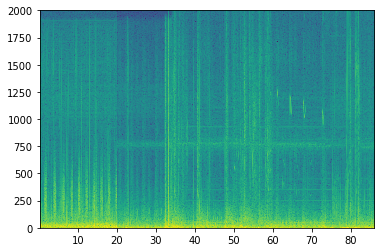

In [14]:
for f in data['audio_file']:
    get_spectro(f)

In [16]:
data['Spectrogram'] = vecs

In [2]:
# TODO: @Priya
# noise augmentation, speeding it up, slowing it down (be careful that it doesn't change too much to undermodel healthy data) balance classes